# Using Principal Component Analysis to classify handwritten digits
Gonna try to recreate my a simple machine learning (ML) model based of principal component analysis (PCA) to analyze the MNIST dataset and classify unlabelled images of digits. Just finished Linear Algebra and wanna apply one of the labs.

In [31]:
import numpy as np
import numpy.linalg as la
import pandas as pd
import matplotlib.pyplot as plt
import idx2numpy

plt.rcParams['figure.figsize'] = (6, 3)

Labels: [5 0 4 1 9]


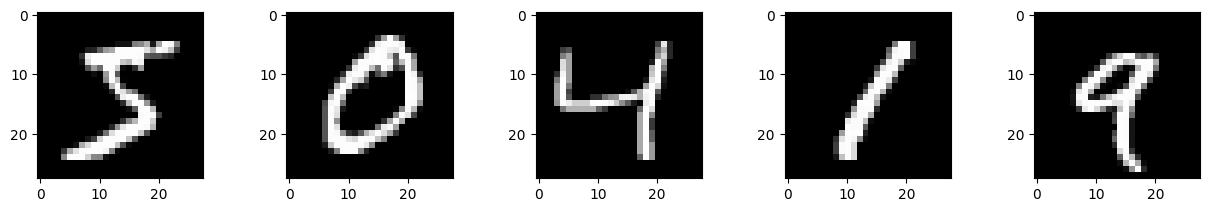

In [36]:
# (60000, 28, 28) images, (60000,) labels
images_2d = idx2numpy.convert_from_file("../data/train-images.idx3-ubyte")
# cover to 2D array (6000, 28 * 28 = 784)
images = images_2d.reshape(images_2d.shape[0], -1)
labels = idx2numpy.convert_from_file("../data/train-labels.idx1-ubyte")

images_shown = 5

print("Labels:", labels[:images_shown])

f, axes = plt.subplots(1, images_shown,
                      figsize=(images_shown * 3, 3),
                      gridspec_kw={'wspace': images_shown/10})
for i, ax in enumerate(axes):
    ax.imshow(images_2d[i], cmap="gray")

## 1) Run PCA on the MNIST images:

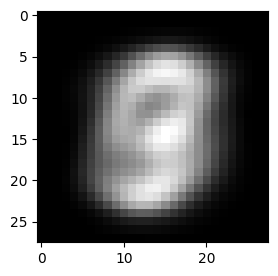

In [37]:
# We need to first center the images so each axias means is zero
# This returns the average image in a 28 x 28 array
mnist_avg = np.average(images, axis=0)
images_shifted = images - mnist_avg

plt.imshow(mnist_avg.reshape((28, 28)), cmap='gray')

In [38]:
# Now that we have the shifted images, we can compute the SVD\
U, S, Vt = la.svd(images_shifted, full_matrices=False)
V = Vt.T

## 2) Apply dimension reduction to PCA:

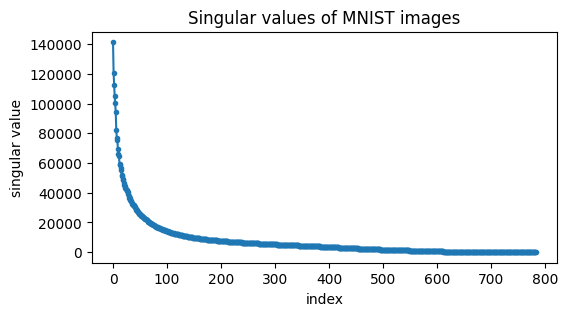

In [39]:
# In this plot we see how the singular values decay
# Showing how the first few singular values capture most of the variance
# These singular values apply a greater weighting to the corresponding singular vectors
plt.plot(S, '.-')
plt.xlabel('index')
plt.ylabel('singular value')
plt.title('Singular values of MNIST images')
plt.show()

(0.0, 50.0)

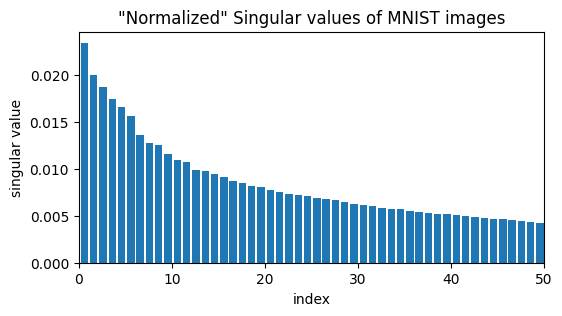

In [40]:
# Normalizing the singular values to show their relative importance
# We see the big difference even in the first 50 singular values
plt.bar(np.arange(len(S)) + .6, S/sum(S))
plt.xlabel('index')
plt.ylabel('singular value')
plt.title('"Normalized" Singular values of MNIST images')
plt.xlim(0,50)

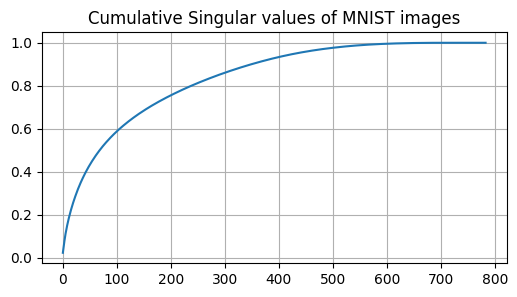

In [41]:
# cum_var is the cumulative sum of the normalized singular values
# Basically the cumulative explained variance - showing how much of the total information is captured as you include more singular values
S_norm = S / np.sum(S)
cum_var = np.cumsum(S_norm)

# This plot shows as we add more singular values, how much of the total variance is captured
# We see how the first 100 singular values capture 60% of the total variance
plt.plot(range(len(S)), cum_var)
plt.title('Cumulative Singular values of MNIST images')
plt.grid()

(0.0, 20.0)

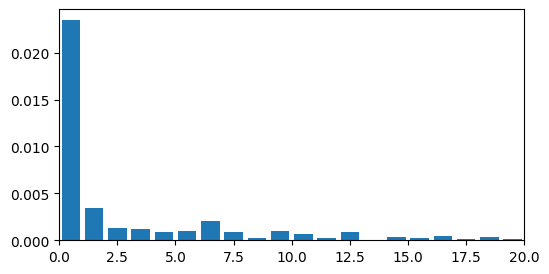

In [42]:
# To find the "kink" in the singular values, we can look for the point where the difference between consecutive singular values increases
# In essence, you want to find the earliest singular value which marks an increased difference from the previous one
# Generally, the (absolute) difference between consecutive singular values should decrease, so identifying the earliest *increase* in these differences will capture any kinks
# like the one we see in the above plot

# This is an array of the difference between consecutive singular values
S_diff = np.append(S_norm[0], np.abs(S_norm[1:] - S_norm[:-1]))
plt.bar(np.arange(len(S)) + .5, S_diff)
plt.xlim(0,20)

In [153]:
# The algorithm is looking for when the rate of decay starts to become irregular
# In a clean exponential decay, each difference should be smaller than the previous one
# But when we hit the "elbow" the singular values stop getting consistently smaller
# And the gaps between them stop getting consistently smaller
# This indicates we've moved past the "important" singular values into the "noise" region

# argmax returns the index of the first occurrence of the maximum value or first true value
reduced_demension = np.argmax(S_diff[1:] - S_diff[:-1] > 0) + 1
# So we cut down from 784 to 5 dimensions
reduced_V = V[:, :reduced_demension]
print(reduced_demension)

5


### 3) Building a nearest-neighbor classifier on MNIST:

In [154]:
# Now that we use PCA to reduce the dimensionality of the images, we can project the original images onto the reduced space
# This next part is a simple machine learning algorithm which is K-Nearest Neighbors (KNN)

# Found it weird why we do this order but (n_samples, n_features) @ (n_features, n_components) = (n_samples, n_components)
# This is the projection of the original images onto the reduced principle components space
flat_images_projected = images @ reduced_V

Labels: [7 2 1 0 4]


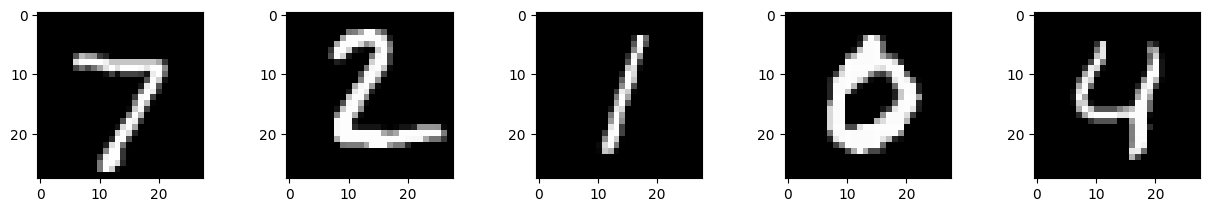

In [155]:
test_images = idx2numpy.convert_from_file("../data/t10k-images.idx3-ubyte")
flat_test_images = test_images.reshape(test_images.shape[0], -1)
test_labels = idx2numpy.convert_from_file("../data/t10k-labels.idx1-ubyte")

test_images_shown = 5

print("Labels:", test_labels[:test_images_shown])

f, axes = plt.subplots(
    1,
    test_images_shown,
    figsize=(test_images_shown * 3, 3),
    gridspec_kw={"wspace": test_images_shown / 10},
)
for i, ax in enumerate(axes):
    ax.imshow(test_images[i], cmap="gray")

In [160]:
image_index = 0
test_projection = (flat_test_images[image_index] - mnist_avg) @ reduced_V
distances = np.linalg.norm(flat_images_projected - test_projection, axis=1)
n = np.argmin(distances)
print(n)

11400


Label: 7


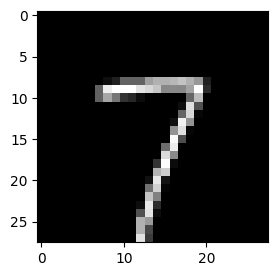

In [162]:
print("Label:", labels[n])
plt.imshow(images[n].reshape((28, 28)), cmap="gray");

### 4) Checks results:

In [ ]:
correct_count = 0
for i in range(flat_test_images.shape[0]):
    test_projection = (flat_test_images[i] - mnist_avg) @ reduced_V
    distances = np.linalg.norm(flat_images_projected - test_projection, axis=1)
    n = np.argmin(distances)
    print("Label:", labels[n])
    print("Test Label:", test_labels[i])
    if labels[n] == test_labels[i]:
        correct_count += 1

print("Correct Count:", correct_count)
print("Total Test Images:", flat_test_images.shape[0])
print("Accuracy:", correct_count / flat_test_images.shape[0])

Label: 7
Test Label: 7
Label: 2
Test Label: 2
Label: 1
Test Label: 1
Label: 0
Test Label: 0
Label: 9
Test Label: 4
Correct Count: 4
Total Test Images: 10000
Accuracy: 0.0004
